# 章节 4：从零开始实现 GPT 模型

- 在本章中，我们将设计一个类似 GPT 的大型语言模型（LLM）架构；下一章则将聚焦于该模型的训练。

<img src="figures/mental-model.webp" width=450px>

## 4.1 设计LLM的架构

- 第1章探讨了如GPT与Llama等模型，这些模型基于transformer架构的decoder部分，并按顺序生成文本。
- 因此，这些LLM经常被称为decoder-only LLM。
- 与传统的深度学习模型相比，LLM更大，这是因为它们有更多的参数，而不是代码量。
- 而在LLM的架构中，有许多元素是重复的。

<img src="figures/mental-model-2.webp" width=350px>

- 在前几章中，为了方便展示，我们使用了较小的嵌入（embedding）维度来处理token的输入和输出。
- 在本章中，我们将考虑与GPT2-small模型类似的嵌入和模型大小。
- 我们将具体实现最小的GPT2-small模型（124M参数）的架构，如Radford等人在[《Language Models are Unsupervised Multitask Learners》](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)中概述的那样（注意，GPT2-small的参数量曾被错误的统计为117M参数，后被更正为124M）。
- 第6章将展示如何将预训练权重加载到我们实现的GPT2中，并兼容345、762和1542M参数的模型大小。

> 译者注：GPT2的论文《Language Models are Unsupervised Multitask Learners》中错误统计了GPT2系列模型的参数量，这一错误后续在模型仓库中被偷偷修正了。
> 
> 错误的参数量：Small (117M)	Medium (345M)	Large (762M)	XL (1542M)
>
> 正确的参数量：Small (124M)	Medium (355M)	Large (774M)	XL (1558M)

- 124M参数GPT-2模型的配置细节包括：

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # 词表大小
    "ctx_len": 1024,      # 上下文长度
    "emb_dim": 768,       # 嵌入维度
    "n_heads": 12,        # 注意力头（attention heads）的数量
    "n_layers": 12,       # 模型层数
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-Key-Value bias
}

- 我们使用简短的变量名以避免后续代码行的过长
- "vocab_size" 是一个BPE tokenizer（分词器），词表大小为50257个词，这在第二章介绍过
- "ctx_len" 表示模型支持输入的最大token数量，这数值由第二章中介绍的位置编码决定
- "emb_dim" 是对输入token的嵌入维度，这里会将输入的每个token都嵌入成768维的向量
- "n_heads" 是多头注意力机制中的注意力头数，这在第三章中实现过
- "n_layers" 是模型中transformer blocks的数量，我们将在接下来的部分中实现它。
- "drop_rate" 是第三章中讨论的dropout机制的强度；0.1表示在训练期间丢弃10％的隐藏神经元以缓解过拟合
- "qkv_bias" 决定第三章中的多头注意力机制中的Linear层在计算Query（Q），Key（K）和Value（V）张量时是否应包含偏置向量（bias）；当代LLM通常不会启用这个选项，我们也不会；但在第六章中将OpenAI预训练的GPT-2权重加载到我们的实现的模型时，会再次讨论此选项。

<img src="figures/chapter-steps.webp" width=350px>

In [2]:
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # 先用空白实现顶替下 TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # 先用空白实现顶替下 LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 略

    def forward(self, x):
        # 先啥也别干，原样返回
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 这里的参数只是为了模拟 LayerNorm 接口。

    def forward(self, x):
        # 先啥也别干，原样返回
        return x

<img src="figures/gpt-in-out.webp" width=350px>

In [3]:
import tiktoken
import torch

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 对激活进行层归一化

- 层归一化（Layer normalization），也叫 LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450))，会将神经网络层的激活值规范到均值为0，并将其方差归一化为1。
- 这稳定了训练过程，并提高了模型的收敛速度。。
- Transformer block中多头注意力模块的输入和输出都会应用LayerNorm，一会会实现它；同时，在最终输出层之前也会应用LayerNorm。

<img src="figures/layernorm.webp" width=350px>

- 咱们用一个简单的网络，输入一个样本看看LayerNorm是怎么工作的。

In [5]:
torch.manual_seed(123)

# 创建两个训练样例，每个样例有5个维度（特征）
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 计算上面两个输入的均值和方差：

In [6]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- LayerNorm 会对输入样本分别归一化（下图中的行）; 使用`dim=-1`是在最后一个维度（特征维度）而不是行维度（样本数）上进行计算

<img src="figures/layernorm2.webp" width=350px>

- 减去均值并除以方差的平方根（标准差）会使输入在列（特征）维度上的均值为0，方差为1：

In [7]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 每个输入的均值都为0，方差都为1；为了提高可读性，我们可以关闭PyTorch的科学计数法：

In [8]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 在上面，我们对每个输入的特征进行了归一化
- 现在，用相同的思路，我们可以实现一个`LayerNorm`类：

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**缩放和偏移**
- 注意，除了通过减去均值并除以方差执行归一化之外，我们还添加了两个可训练参数，一个是 `scale`，另一个是 `shift`。
- 初始的 scale（乘以1）和 shift（加0）值没有任何效果；然而，scale 和 shift 是可训练的参数，如果确定这样做可以改善模型在训练任务上的性能，LLM 在训练过程中会自动调整它们。
- 这使得模型能够学习适合其处理数据的适当缩放和偏移。
- 注意，在计算方差的平方根之前，我们还添加了一个较小的值（eps）；这是为了避免在方差为0时发生分母为0的问题。

**有偏方差**
- 在上面的方差计算中，设置 `unbiased=False` 意味着用 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 来计算方差，其中 n 是样本大小（在这里是特征或列数）；这个公式不包括 Bessel 修正（分母是 n-1），因此得到的方差是有偏估计。
- 因为LLM的嵌入维度很高，所以使用 n 或 n-1 （有偏或无偏）的区别不大。
- 但 GPT-2 在LayerNorm中使用了有偏方差进行训练，为了在后续章节能加载现有的预训练权重，咱需要`unbiased`这个变量做兼容。

- 下面手动实现下 LayerNorm：

In [10]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [11]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="figures/overview-after-ln.webp" width=350px>

## 4.3 使用GELU激活函数实现前馈神经网络

- 在这一节中，我们将实现一个网络子模块，该模块将作为LLM中Transformer block的一部分
- 我们从激活函数开始
- 在深度学习中，由于ReLU（Rectified Linear Unit）激活函数在各种神经网络架构中的简单性和有效性，它们经常被使用
- 在LLM中，除了ReLU之外，还使用了其他类型的激活函数；其中两个值得注意的例子是GELU（Gaussian Error Linear Unit）和SwiGLU（Sigmoid-Weighted Linear Unit）
- GELU和SwiGLU是更复杂的、平滑的激活函数，它们分别结合了高斯和Sigmoid门控线性单元，为深度学习模型提供了更好的性能，与ReLU的简单分段线性函数不同

- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))用多种实现；其精确版本定义为$GELU(x)=x\cdot \phi(x)$，其中$\phi(x)$是标准高斯分布的累积分布函数。
- 在实际应用中，常常采用计算成本较低的近似形式：$\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$（原始的GPT-2模型也是使用这个近似形式进行训练的）。

In [12]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

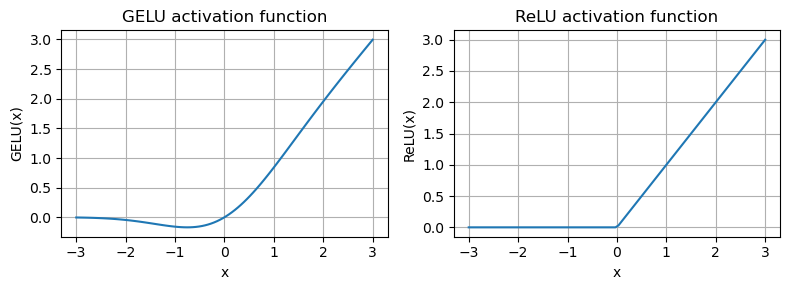

In [13]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 显然，ReLU是一个分段线性函数，如果输入是正值，它直接原样输出；否则，输出为零。
- GELU是一个平滑的非线性函数，近似于ReLU，但输入为负值时，梯度不为0。
- 接下来，让我们实现小型神经网络模块 FeedForward，稍后我们将在LLM的Transformer block中使用它：

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            nn.Dropout(cfg["drop_rate"])
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
print(GPT_CONFIG_124M["emb_dim"], GPT_CONFIG_124M["drop_rate"])

768 0.1


<img src="figures/ffn.webp" width=350px>

In [16]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="figures/mental-model-3.webp" width=350px>

## 4.4 添加Shortcut连接

- 接下来，我们将探讨shortcut连接，这也被称为跳跃连接或残差连接
- 最初，shortcut连接在计算机视觉的深度神经网络(残差网络)中被提出，以缓解消失梯度问题
- Shortcut连接为网络中传播的梯度提供了一条更短的路径
- 这是通过将一个层的输出加到后面层的输出上来实现，通常跳过中间的一个或多个层
- 让我们通过一个小的示例网络来说明这个思想：

<img src="figures/shortcut-example.webp" width=350px>

- 示例代码如下:

In [17]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # 计算当前层的输出
            layer_output = layer(x)
            # 检查是否可以使用shortcut
            if self.use_shortcut and x.size() == layer_output.size():
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # 前向传播
    output = model(x)
    target = torch.tensor([[0.]])

    # 根据输出和标签差距来计算损失
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # 反向传播计算梯度
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 打印权重的平均绝对梯度
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 让我们先打印**不使用**shortcut连接的梯度值:

In [18]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011158833047375
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


- 接下来我们打印**使用**shortcut连接的梯度值

In [19]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169794142246246
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


- 从上述输出可以看出，shortcut连接可以防止梯度在浅层（靠近layer.0）中消失。
- 接下来，我们将在实现Transformer块时应用shortcut连接。

## 4.5 在transformer块中连接注意力层和线性层

- 本节将前述概念融合，搭建transformer块。
- Transformer块将前一章的因果多头注意力模块与线性层结合起来，即之前章节中我们实现的前馈神经网络
- 此外，transformer块还使用了Dropout和shortcut连接。

In [20]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            block_size=cfg["ctx_len"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 注意力块中的Shortcut连接
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_resid(x)
        x = x + shortcut  # 与原始输入块求和

        # 前馈块中的Shortcut连接
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut  # 与原始输入块求和

        return x

<img src="figures/transformer-block.webp" width=350px>

- 假设我们有2个输入样本，每个样本包含6个token，且每个token都是一个768维的embedding向量。此时，Transformer块会对输入进行自注意力计算，接着进行线性变换，得到一个与输入形状相同的输出。
- 我们可以将这个输出视为前一章中所讨论的上下文向量的增强版本。

In [21]:
# print(f"gpt config is: \n{GPT_CONFIG_124M}")
print("GPT config is: ")
for k, v in GPT_CONFIG_124M.items():
    print(f"{k}: {v}")

torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

GPT config is: 
vocab_size: 50257
ctx_len: 1024
emb_dim: 768
n_heads: 12
n_layers: 12
drop_rate: 0.1
qkv_bias: False
Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [22]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="figures/mental-model-final.webp" width=350px>

## 4.6 编写GPT模型

- 我们已经接近成功了：现在让我们将transformer块集成到我们在本章开头编写的架构中，以便获得功能强大的GPT架构
- 请注意，transformer块被重复多次使用；在最小的124M GPT-2模型中，我们重复了12次：

<img src="figures/gpt.webp" width=350px>

- 对应的代码实现，其中 `cfg["n_layers"] = 12`:

In [23]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        # self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 我们现在可以按照如下方式，采用124M参数模型的配置，以随机初始化权重的方式实例化这个GPT模型

In [24]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.0055,  0.3224,  0.2185,  ...,  0.2539,  0.4578, -0.4747],
         [ 0.2663, -0.2975, -0.5040,  ..., -0.3903,  0.5328, -0.4224],
         [ 1.1146, -0.0923,  0.1303,  ...,  0.1521, -0.4494,  0.0276],
         [-0.8239,  0.1174, -0.2566,  ...,  1.1197,  0.1036, -0.3993]],

        [[-0.1027,  0.1752, -0.1048,  ...,  0.2258,  0.1559, -0.8747],
         [ 0.2230,  0.1246,  0.0492,  ...,  0.8573, -0.2933,  0.3036],
         [ 0.9409,  1.3068, -0.1610,  ...,  0.8244,  0.1763,  0.0811],
         [ 0.4395,  0.2753,  0.1540,  ...,  1.3410, -0.3709,  0.1643]]],
       grad_fn=<UnsafeViewBackward0>)


- 我们将在下一章对这个模型进行训练。
- 这里对模型大小做一个快速说明：我们之前提到它是一个拥有124M参数的模型；可以按照以下方式核对这个数字：

In [25]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")
# 163,059,793

Total number of parameters: 163,009,536


- 正如我们看到的，这个模型的参数量为163M个，而不是124M个；为什么呢？
- 在原始的GPT-2论文中，研究人员使用了权重绑定，这意味着他们将token嵌入层（tok_emb）重复用作输出层，即设置`self.out_head.weight = self.tok_emb.weight`
- token嵌入层将50,257维输入token的one-hot编码投影到768维的embedding表示中
- 输出层将768维的embedding投影回到50,257维的表示中，以便我们可以将其转换回单词（更多关于此的信息请参见下一节）
- 因此，embedding层和输出层有相同数量的权重参数，正如我们根据其权重矩阵的形状所看到的那样

In [26]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- 在原始的GPT-2论文中，研究人员将标记嵌入矩阵重复用作输出矩阵
- 因此，如果我们减去输出层的参数数量，就会得到一个124M参数的模型：

In [27]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- 在实践中，我发现在没有权重绑定时训练模型更容易，这就是为什么在这里我们没有实现它的原因。
- 然而，在第六章加载预训练权重时，我们将重新审视并应用这个权重绑定的想法。
- 最后，我们可以按以下方式计算模型的内存需求，这可以作为一个有用的参考点：

In [28]:
# 计算总字节大小（假设每个参数均为占用4个字节的float32类型） 
total_size_bytes = total_params * 4

# 转换为兆字节（MB）
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [33]:
# 具体查看GPT模型各个模块的参数量
trf_blocks_params_num = 0
for name, param in model.named_parameters():
    if name.startswith("trf_"):
        trf_blocks_params_num += param.numel()
    else:
        print(f"{name}: {param.numel()}")
print(f"trf_block: {trf_blocks_params_num}")

tok_emb.weight: 38597376
pos_emb.weight: 786432
final_norm.scale: 768
final_norm.shift: 768
out_head.weight: 38597376
trf_block: 85026816


- 练习：你可以尝试实现以下其他配置，这些配置也在 [GPT-2 论文](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)中提到.

    - **GPT2-small** (我们已经实现的124M参数配置):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 生成文本

- LLMs（如我们上面实现的GPT模型）一次生成一个单词。

<img src="figures/iterative-gen.webp" width=350px>

- 下面的 `generate_text_simple` 函数实现了贪婪解码，这是一种简单快速的文本生成方法
- 在贪婪解码中，模型在每一步都选择概率最高的单词（或 token）作为其下一个输出（最高的 logits 输出对应于最高的概率，所以我们甚至不需要显式地计算 softmax 函数）
- 在下一章中，我们将实现一个更高级的 `generate_text` 函数
- 下图描述了 GPT 模型如何在给定输入上下文的情况下生成下一个单词 token

<img src="figures/generate-text.webp" width=350px>

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx是当前上下文中的索引数组，形状为(B, T)
    for _ in range(max_new_tokens):

        # 如果当前上下文超过了支持的长度，就对当前上下文进行截断
        # 例如，如果LLM只支持5个token，而上下文长度为10，
        # 那么只有最后5个token会被用作上下文

        idx_cond = idx[:, -context_size:]
        
        # 获取预测结果
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 只关注最后一个时间步
        # (batch, n_token, vocab_size)变为(batch, vocab_size)
        logits = logits[:, -1, :]  

        # 通过softmax函数获得对应的概率
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # 获取概率值最高的单词索引
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # 将采样到的索引添加到当前运行的上下文索引序列中
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- 上述的 `generate_text_simple` 函数实现了一次迭代过程，它一次生成一个token。

<img src="figures/iterative-generate.webp" width=350px>

- 让我们准备一个输入示例：

In [ ]:
b = logits[0, -1, :]
b[0] = -1.4929
b[1] = 4.4812
b[2] = -1.6093

print(b[:3])
torch.softmax(b, dim=0)

tensor([-1.4929,  4.4812, -1.6093], grad_fn=<SliceBackward0>)


tensor([    0.0000,     0.0012,     0.0000,  ...,     0.0000,     0.0000,
            0.0000], grad_fn=<SoftmaxBackward0>)

In [ ]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval() # 关闭 dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["ctx_len"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- 移除批次维度并转回文本：

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)  # 由于分词算法使用的是基于subword粒度的BPE算法，所以解码后得到的序列长度有可能少于解码前的tokens序列长度

Hello, I am Featureiman Byeswickattribute argue


- 请注意，该模型尚未训练；因此上述文本是随机生成的
- 我们将在下一章训练这个模型